In [1]:
import pyarrow.plasma as plasma
import pyarrow as pa
import numpy as np

import cv2
from PIL import Image

import os

#### plasma store 연결

In [2]:
plasma_store_path = '/tmp/plasma_store'
client = plasma.connect(plasma_store_path)
client.list()

{}

####  numpy ndarray 형식으로 이미지 로드 

In [3]:
img_path = './dog-cycle-car.png'
img = cv2.imread(img_path) # image load 
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # BGR -> RGB convert 
img.shape

(452, 602, 3)

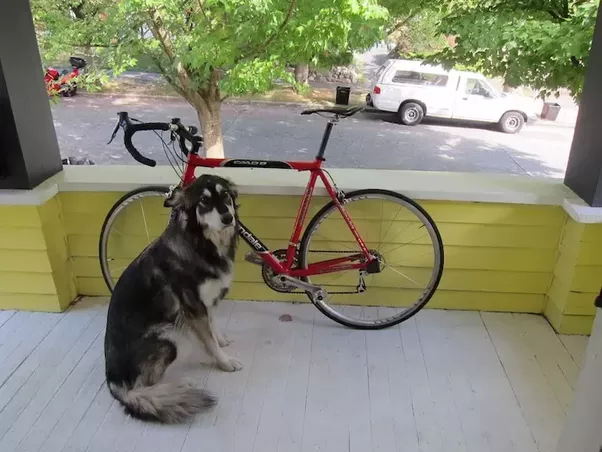

In [4]:
Image.fromarray(img)

#### serialization, put

In [5]:
serialized_frame = pa.serialize(img)
serialized_frame_buf = serialized_frame.to_buffer() # buffer로 보낸 후 put 
client.put(serialized_frame_buf)

ObjectID(8a55083957d6dbd2a1b001408fe1f4452fc29fa2)

In [6]:
client.list()

{ObjectID(8a55083957d6dbd2a1b001408fe1f4452fc29fa2): {'data_size': 817608,
  'metadata_size': 0,
  'ref_count': 0,
  'create_time': 1595832133,
  'construct_duration': 0,
  'state': 'sealed'}}

#### 지정한 Object ID로 put

In [7]:
object_id = plasma.ObjectID(b'a'*20)
client.put(serialized_frame_buf, object_id)

ObjectID(6161616161616161616161616161616161616161)

In [8]:
client.list()

{ObjectID(8a55083957d6dbd2a1b001408fe1f4452fc29fa2): {'data_size': 817608,
  'metadata_size': 0,
  'ref_count': 0,
  'create_time': 1595832133,
  'construct_duration': 0,
  'state': 'sealed'},
 ObjectID(6161616161616161616161616161616161616161): {'data_size': 817608,
  'metadata_size': 0,
  'ref_count': 0,
  'create_time': 1595832134,
  'construct_duration': 0,
  'state': 'sealed'}}

In [9]:
object_id = plasma.ObjectID(np.random.bytes(20))
client.put(serialized_frame_buf, object_id)

ObjectID(8d40560ea902e7d85ad40fea2fab67463d052cec)

In [10]:
client.list()

{ObjectID(8a55083957d6dbd2a1b001408fe1f4452fc29fa2): {'data_size': 817608,
  'metadata_size': 0,
  'ref_count': 0,
  'create_time': 1595832133,
  'construct_duration': 0,
  'state': 'sealed'},
 ObjectID(8d40560ea902e7d85ad40fea2fab67463d052cec): {'data_size': 817608,
  'metadata_size': 0,
  'ref_count': 0,
  'create_time': 1595832146,
  'construct_duration': 0,
  'state': 'sealed'},
 ObjectID(6161616161616161616161616161616161616161): {'data_size': 817608,
  'metadata_size': 0,
  'ref_count': 0,
  'create_time': 1595832134,
  'construct_duration': 0,
  'state': 'sealed'}}

#### Get

In [11]:
object_id = plasma.ObjectID(b'a'*20)
serialized_object = client.get(object_id)
serialized_object

In [12]:
deserialized_object = pa.deserialize(serialized_object)
print (type(deserialized_object))
print (deserialized_object.shape)

<class 'numpy.ndarray'>
(452, 602, 3)


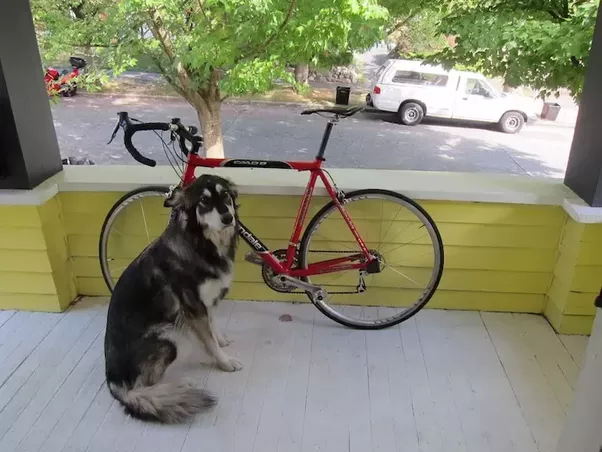

In [13]:
Image.fromarray(deserialized_object)

#### plasma store에서 object 삭제 

In [14]:
client.list()

{ObjectID(8a55083957d6dbd2a1b001408fe1f4452fc29fa2): {'data_size': 817608,
  'metadata_size': 0,
  'ref_count': 0,
  'create_time': 1595832133,
  'construct_duration': 0,
  'state': 'sealed'},
 ObjectID(8d40560ea902e7d85ad40fea2fab67463d052cec): {'data_size': 817608,
  'metadata_size': 0,
  'ref_count': 0,
  'create_time': 1595832146,
  'construct_duration': 0,
  'state': 'sealed'},
 ObjectID(6161616161616161616161616161616161616161): {'data_size': 817608,
  'metadata_size': 0,
  'ref_count': 1,
  'create_time': 1595832134,
  'construct_duration': 0,
  'state': 'sealed'}}

In [15]:
object_ids = list(client.list().keys())
object_ids[0]

ObjectID(8a55083957d6dbd2a1b001408fe1f4452fc29fa2)

In [16]:
client.delete([object_ids[0]]) # iterable 형태로 object id를 전달해주어야 함 
client.list() # object_ids[0] 삭제된 것 확인 

{ObjectID(6161616161616161616161616161616161616161): {'data_size': 817608,
  'metadata_size': 0,
  'ref_count': 1,
  'create_time': 1595832134,
  'construct_duration': 0,
  'state': 'sealed'},
 ObjectID(8d40560ea902e7d85ad40fea2fab67463d052cec): {'data_size': 817608,
  'metadata_size': 0,
  'ref_count': 0,
  'create_time': 1595832146,
  'construct_duration': 0,
  'state': 'sealed'}}

#### ref_count 
ref_count 가 0보다 큰 경우에는 해당 object를 삭제할 수 없음, 
참조 해제 후 삭제해 주어야 함

In [33]:
client.list()

{ObjectID(8d40560ea902e7d85ad40fea2fab67463d052cec): {'data_size': 817608,
  'metadata_size': 0,
  'ref_count': 0,
  'create_time': 1595832146,
  'construct_duration': 0,
  'state': 'sealed'},
 ObjectID(6161616161616161616161616161616161616161): {'data_size': 817608,
  'metadata_size': 0,
  'ref_count': 0,
  'create_time': 1595832321,
  'construct_duration': 0,
  'state': 'sealed'}}

In [34]:
object_id = plasma.ObjectID(b'a'*20)
[serialized_object] = client.get([object_id]) # GET 시 ref_count 1 증가 
client.list()

{ObjectID(8d40560ea902e7d85ad40fea2fab67463d052cec): {'data_size': 817608,
  'metadata_size': 0,
  'ref_count': 0,
  'create_time': 1595832146,
  'construct_duration': 0,
  'state': 'sealed'},
 ObjectID(6161616161616161616161616161616161616161): {'data_size': 817608,
  'metadata_size': 0,
  'ref_count': 1,
  'create_time': 1595832321,
  'construct_duration': 0,
  'state': 'sealed'}}

In [35]:
client.delete([object_id]) # 삭제 시도 -> ObjectID(6161616161616161616161616161616161616161) object가 그대로 남아 있음  
client.list()

{ObjectID(8d40560ea902e7d85ad40fea2fab67463d052cec): {'data_size': 817608,
  'metadata_size': 0,
  'ref_count': 0,
  'create_time': 1595832146,
  'construct_duration': 0,
  'state': 'sealed'},
 ObjectID(6161616161616161616161616161616161616161): {'data_size': 817608,
  'metadata_size': 0,
  'ref_count': 1,
  'create_time': 1595832321,
  'construct_duration': 0,
  'state': 'sealed'}}

In [36]:
del(serialized_object) # client.get 에 사용한 변수를 해제 해줌으로써 plasma store object 참조 해제 -> ref_count 감소
client.delete([object_id])
client.list()

{ObjectID(8d40560ea902e7d85ad40fea2fab67463d052cec): {'data_size': 817608,
  'metadata_size': 0,
  'ref_count': 0,
  'create_time': 1595832146,
  'construct_duration': 0,
  'state': 'sealed'}}

#### plasma store client 연결 해제

In [87]:
client.disconnect()